In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, classification_report
import matplotlib.pyplot as plt
from lib.transformers_explainability import *

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.TwitterDataCleaned
DATASET_NAME = 'TwitterData'
MODEL_NAME = 'Roberta'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
FROZEN_LAYERS = 9
EPOCHS = 6
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

# Cross Validation

In [ ]:
params_to_explore = {
    'learning_rate': [5e-05, 1e-05],
    'regularization': [0, 1e-05],
    'batch_size': [16, 32],
    'epochs': [EPOCHS],
    'frozen_layers': [FROZEN_LAYERS],
    'n_classes': [len(LABEL_COLS)],
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Roberta, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

In [4]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['frozen_layers'] = int(BEST_PARAMS['frozen_layers'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])

BEST MODEL INFO
{'batch_size': 16, 'epochs': 6, 'frozen_layers': 9, 'learning_rate': 5e-05, 'n_classes': 6, 'regularization': 1e-05, 'train_accuracy': 0.9321875, 'train_jaccard_macro': 0.8482441887155151, 'train_f1_macro': 0.9160400436521958, 'train_jaccard_samples': 0.93828125, 'train_f1_micro': 0.9415419373058458, 'train_membership': 0.94225, 'val_accuracy': 0.908, 'val_jaccard_macro': 0.817514805477724, 'val_f1_macro': 0.8982870320320332, 'val_jaccard_samples': 0.91425, 'val_f1_micro': 0.9188914314772438, 'val_membership': 0.915}
RESULTS
  batch_size epochs frozen_layers  learning_rate n_classes regularization  \
0         16      6             9        0.00005         6              0   
1         32      6             9        0.00005         6              0   
2         16      6             9        0.00005         6        0.00001   
3         32      6             9        0.00005         6        0.00001   
4         16      6             9        0.00001         6          

In [5]:
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

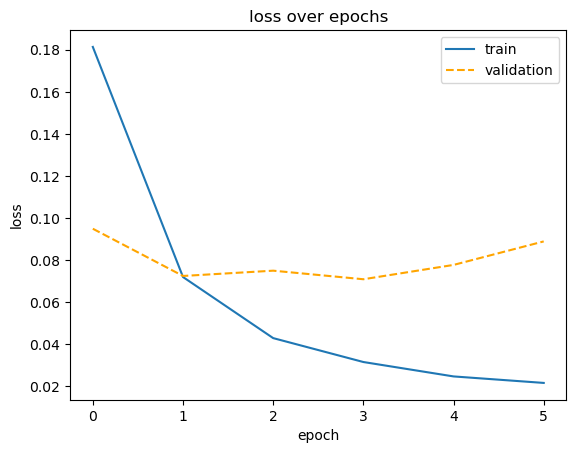

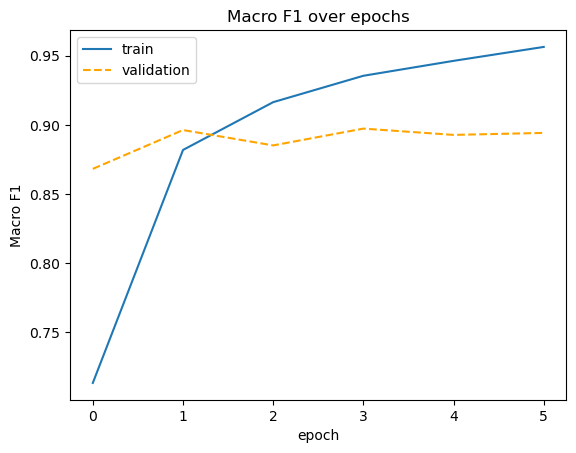

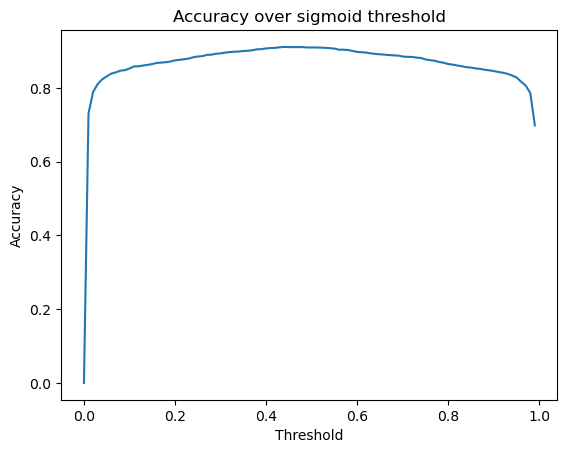

Best threshold: 0.44
Best Accuracy: 0.9115


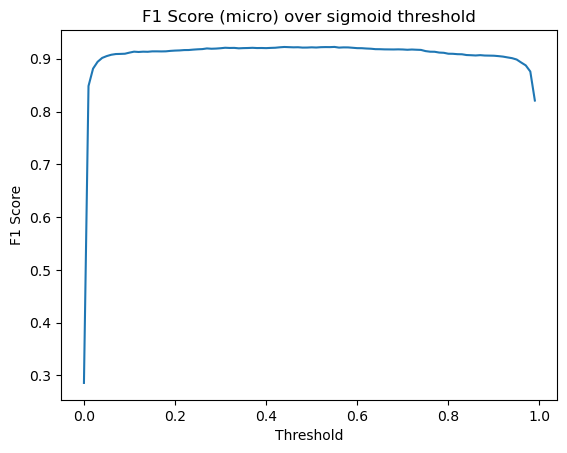

Best threshold: 0.55
Best F1 Score (micro): 0.922453117080588


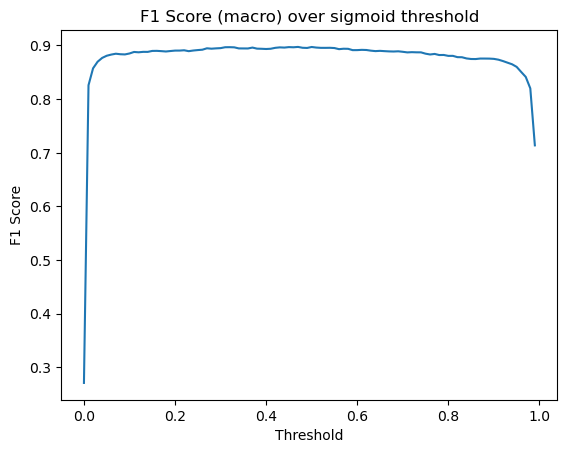

Best threshold: 0.47000000000000003
Best F1 Score (macro): 0.8973276654606712


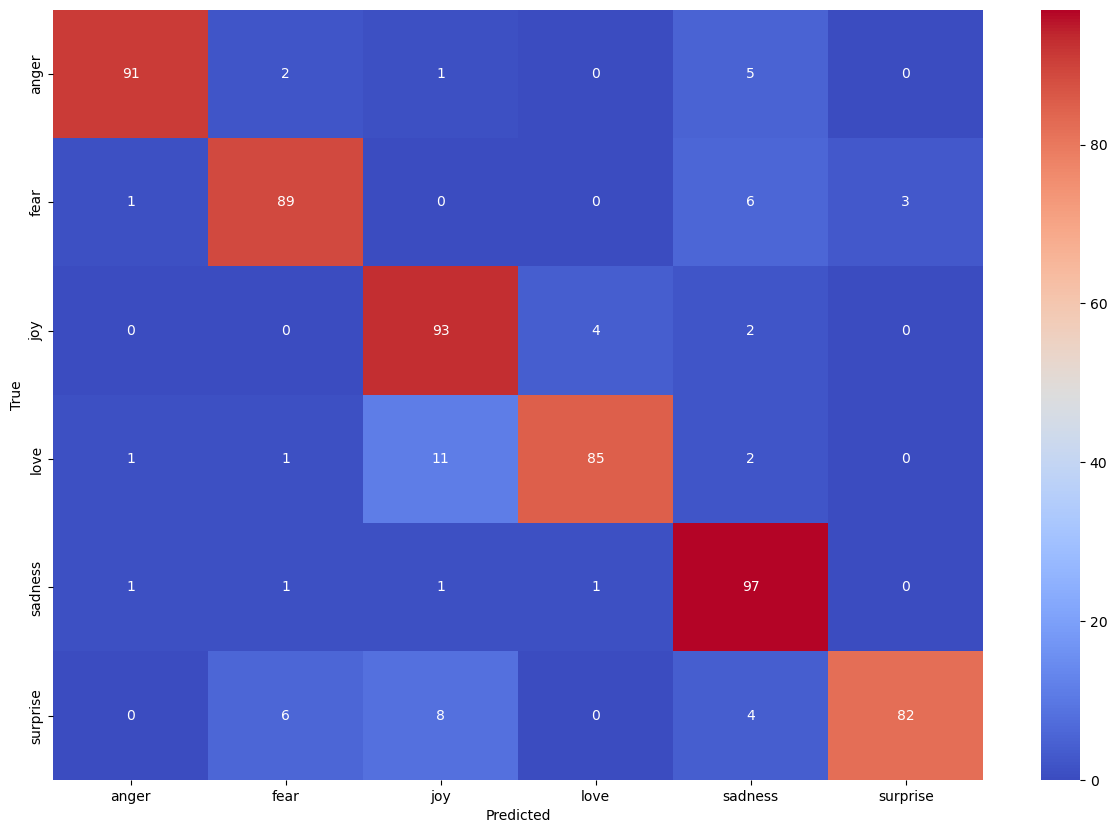

              precision    recall  f1-score   support

       anger       0.96      0.90      0.93       275
        fear       0.89      0.86      0.88       212
         joy       0.95      0.94      0.94       704
        love       0.82      0.86      0.84       178
     sadness       0.92      0.97      0.94       550
    surprise       0.89      0.81      0.85        81

   micro avg       0.92      0.92      0.92      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.92      0.92      0.92      2000
 samples avg       0.92      0.92      0.92      2000

Jaccard Samples Score: 0.9155
Jaccard Macro Score: 0.8165394821656857
Membership Score: 0.922


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


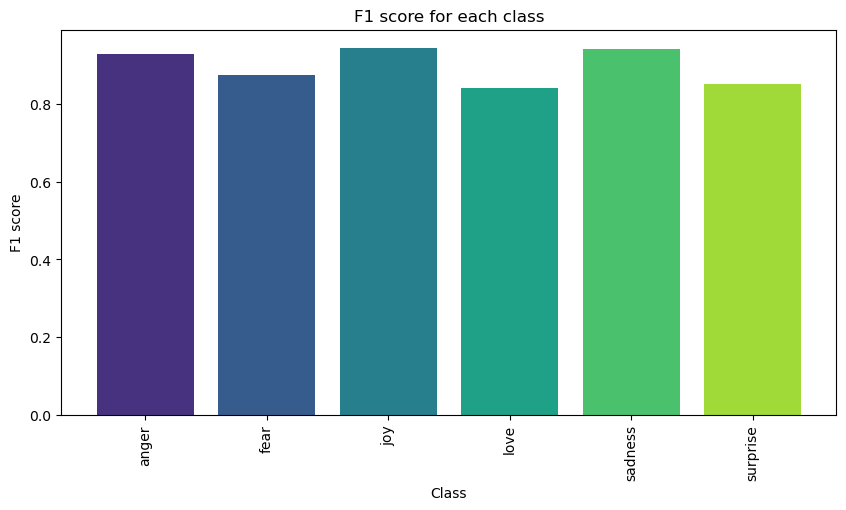

In [6]:
model_analysis(model, val_df, LABEL_COLS)